In [1]:
import json
import requests
from pprint import pprint
from requests.adapters import HTTPAdapter, Retry

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas.datasets import get_path as gpd_get_datapath
from objectpath import Tree

from config import session_headers, data_bucket_of_the_day


In [2]:
# TODO
#  - Turn it right way round: use the location of the real place, not the guess
#     * Get country code, lat, lng from pageProps.game.rounds[*].panorama
#  - Implement paging when fetching games from feed

### Set up session

In [3]:
class TimeoutHTTPAdapter(HTTPAdapter):
    def __init__(self, *args, **kwargs):
        if "timeout" in kwargs:
            self.timeout = kwargs["timeout"]
            del kwargs["timeout"]
        super().__init__(*args, **kwargs)

    def send(self, request, **kwargs):
        timeout = kwargs.get("timeout")
        if timeout is None and hasattr(self, "timeout"):
            kwargs["timeout"] = self.timeout
        return super().send(request, **kwargs)

session = requests.Session()
session.headers.update(session_headers)

# Timeout to prevent hanging
timeout = 10
session.mount("http://", TimeoutHTTPAdapter(timeout=timeout))
session.mount("https://", TimeoutHTTPAdapter(timeout=timeout))

# Do retries
retries = Retry(total=3, backoff_factor=2, status_forcelist=[429, 500, 502, 503, 504])
session.mount("http://", HTTPAdapter(max_retries=retries))
session.mount("https://", HTTPAdapter(max_retries=retries))


### Get game ids

In [4]:
def get_game_ids_from_json(json_string):
    game_ids = []
    s = [('', 0)]
    s.append(("sad", 1))
    json_string_to_process = [(json_string, 0)]
    # for each json string, load it, find all gameId-values. Then find all payloads, and if it's a string, add it to the list.
    while json_string_to_process:
        json_string, level = json_string_to_process.pop()
        json_loaded = json.loads(json_string)
        tree = Tree(json_loaded)
        # find all gameIds
        game_ids.extend(tree.execute("$..gameId"))
        # find all payloads
        payloads = list(tree.execute("$..payload"))
        print(f"found {len(payloads)} payloads on level {level}")
        # if it's a string, add it to the list
        for payload in payloads:
            if isinstance(payload, str):
                json_string_to_process.append((payload, level + 1))
    return game_ids


In [5]:
feed_endpoint = "https://www.geoguessr.com/api/v4/feed/private"

params = {
    "count": 26,
}

response = session.get(feed_endpoint, params=params)

game_ids = get_game_ids_from_json(response.text)

print(f"found {len(game_ids)} game ids")
# pprint(game_ids)


found 21 payloads on level 0
found 0 payloads on level 1
found 2 payloads on level 1
found 3 payloads on level 1
found 2 payloads on level 1
found 4 payloads on level 1
found 0 payloads on level 1
found 0 payloads on level 1
found 10 payloads on level 1
found 0 payloads on level 1
found 20 payloads on level 1
found 5 payloads on level 1
found 9 payloads on level 1
found 4 payloads on level 1
found 35 payloads on level 1
found 8 payloads on level 1
found 0 payloads on level 1
found 2 payloads on level 1
found 0 payloads on level 1
found 0 payloads on level 1
found 8 payloads on level 1
found 0 payloads on level 1
found 113 game ids


### Get game data

In [6]:
from dataclasses import dataclass


def get_user_team(teams: list, user_id: str) -> dict | None:
    # Return the team dict for the given user_id or None if not found
    for team in teams:
        for player in team["players"]:
            if player["playerId"] == user_id:
                return team
    return None


@dataclass
class BestGuess:
    time_created: int
    round_number: int
    lat: float
    lng: float
    distance: int
    score: int
    is_teams_best_guess_on_round: bool
    healthBefore: int
    healthAfter: int


def get_best_guesses_from_team_dict(team_dict: dict) -> list[BestGuess]:
    rounds = team_dict["roundResults"]
    best_guesses = []
    for round in rounds:
        best_guess = round["bestGuess"]
        # No guess was made
        if best_guess is None:
            continue
        best_guess_extended = BestGuess(
            time_created=best_guess["created"],
            round_number=round["roundNumber"],
            lat=best_guess["lat"],
            lng=best_guess["lng"],
            distance=best_guess["distance"],
            score=round["score"],
            is_teams_best_guess_on_round=best_guess["isTeamsBestGuessOnRound"],
            healthBefore=round["healthBefore"],
            healthAfter=round["healthAfter"],
        )
        best_guesses.append(best_guess_extended)
    return best_guesses


def fetch_game(game_id: str):
    game_url_template = "https://www.geoguessr.com/_next/data/{}/en/duels/{}/summary.json"
    print(f"processing game {game_id}")
    game_url = game_url_template.format(data_bucket_of_the_day, game_id)
    response = session.get(game_url)
    try:
        game_json = response.json()
    except json.decoder.JSONDecodeError as e:
        print(f"json decode error. game_id: {game_id}")
        print(f"response text: {response.text}")
        raise e
    status = game_json["pageProps"]["statusCode"]
    if status != 200:
        print(f"status code was {status}, skipping. game_id: {game_id}")
        return None
    return game_json


def process_game(game_id: str):
    game_json = fetch_game(game_id)
    if game_json is None:
        return None
    user_id = game_json["pageProps"]["userId"]
    teams = game_json["pageProps"]["game"]["teams"]
    user_team = get_user_team(teams, user_id)
    if user_team is None:
        raise RuntimeError(
            "the authenticated user isn't in this game, something went horribly wrong"
        )
    is_solo = user_team["isEveryTeamSolo"]
    if not is_solo:
        return None
    best_guesses = get_best_guesses_from_team_dict(user_team)
    return best_guesses


In [7]:
from time import sleep


DELAY = 0.25

all_best_guesses = []
for game_id in game_ids:
    best_guesses = process_game(game_id)
    if best_guesses is not None:
        all_best_guesses.extend(best_guesses)
    sleep(DELAY)

print(f"found {len(all_best_guesses)} best guesses")
print(f"first best guess: {all_best_guesses[0]}")


processing game 547cc6f1-b458-4436-90c3-0c3ebb076153
processing game 07022cee-b1e7-4618-a9e0-1ebe28103f8d
processing game da11c537-904d-4fcf-a594-7b821f6fb42c
processing game 5a844811-60ff-443f-a4fe-40407c8449e6
processing game e2c899a4-88d1-4c34-959a-927b1472fa7b
processing game 9846262f-956b-4000-8d70-e2ac9362288d
processing game ac4a4c45-94be-4a7f-ac9f-516830e66d65
processing game e6c88cd9-b585-4720-98d1-867e7c0af0b9
processing game 684c3f3d-710f-47cc-800e-627ad4098e07
status code was 404, skipping. game_id: 684c3f3d-710f-47cc-800e-627ad4098e07
processing game e74b1094-b3cf-4804-b4c8-9ba895ea40fb
processing game e89fa8a5-0ae8-426c-956c-509c88c46698
processing game f5dac79a-efda-47d6-9e18-0f4ea1d63696
processing game b87b908c-0f0a-41bd-bc4c-14e38e96032e
status code was 404, skipping. game_id: b87b908c-0f0a-41bd-bc4c-14e38e96032e
processing game 80a729f6-a367-4a63-89a1-ae1a24497f1b
processing game 7b3390da-2d75-409d-b50a-5542293d4363
status code was 404, skipping. game_id: 7b3390da-2d

### Visualize

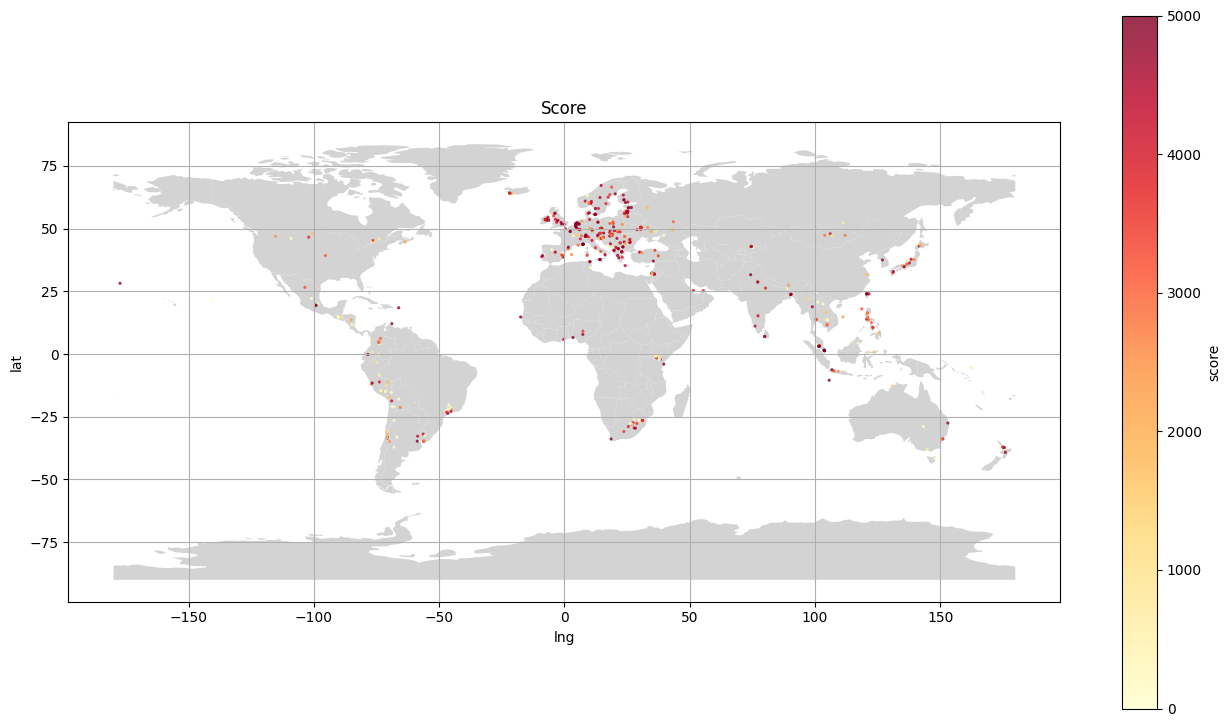

In [9]:
# initialize an axis
import dataclasses

continental_europe_and_iceland = {
    "xlim": (-30, 45),
    "ylim": (30, 85),
}

bbox = {}

fig, ax = plt.subplots(figsize=(16, 9))
# plot map on axis
countries = gpd.read_file(gpd_get_datapath("naturalearth_lowres"))
europe_including_turkey = countries[(countries["continent"] == "Europe") | (countries["name"] == "Turkey")]
countries.plot(color="lightgrey", ax=ax)

best_guesses_dicts = [dataclasses.asdict(best_guess) for best_guess in all_best_guesses]
df = pd.DataFrame(best_guesses_dicts)
# gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lng, df.lat))
df.plot(
    x="lng",
    y="lat",
    kind="scatter",
    c="score",
    colormap="YlOrRd",
    title=f"Score",
    ax=ax,
    grid=True,
    s=5,
    linewidth=0,
    alpha=0.8,
    **bbox,
)
plt.show()
